# NTU Tutorial 2: Volatility Models and Kelly Fraction

In [3]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import sys
import os
from statsmodels.tsa.stattools import acf, pacf, ccf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, t, ecdf
import arch
from statsmodels.stats.diagnostic import acorr_ljungbox

## 0. Functions 

### 0.1 ACF/PACF

In [6]:
from statsmodels.tsa.tsatools import lagmat2ds

def partial_correlation(X: np.ndarray, i, j):
    r"""
    Given Precision Matrix P from data X, PartialCorr(X_i, X_j | X \ {X_i, X_j})
    = (-1) * P[i,j] / np.sqrt(P[i, i] * P[j, j])
    """
    cov_mat = np.cov(X, rowvar=False)
    prec_mat = np.linalg.inv(cov_mat)
    partial_corr = - prec_mat[i, j] / np.sqrt(prec_mat[i, i]) / np.sqrt(prec_mat[j, j])
    return partial_corr


def calc_acf(y: pd.Series, x=None, nlags=10):
    """
    :param x: if not provided, it will be y itself (autocorrelation)
    :return: Corr(X_{t}, Y_{t+i})
    """

    if x is None:
        x = y
        lag_grids = range(1, nlags + 1)
    else:
        lag_grids = range(-nlags, nlags + 1)
                
    acf = pd.Series({i: x.shift(i).corr(y) for i in lag_grids})
    acf = acf.rename_axis("i")
    return acf


def calc_pacf(y: pd.Series, x=None, nlags=10):
    """
    Copmute Time Series Partial Correlation:
    1. If only y is provided: 
    (a). Corr(Y_{t}, Y_{t+i}) for i = 1
    (b). Corr(Y_{t}, Y_{t+i} | Y_{t+1} to Y_{t+i-1}) for i >= 2
    
    2. If x & y are provided: 
    (a). Corr(X_{t}, Y_{t+i}) for i = 0.
    (b). Corr(X_{t}, Y_{t+i} | Y_{t}) for i = 1.
    (c). Corr(X_{t}, Y_{t+i} | X_{t+1} to X_{t+i-1} & Y_{t} to Y_{t+i-1}) for i >= 2.
    (d). Swap (X_{t}, Y_{t}) for i < 0
    """
    pacf = {}
    
    if x is None:
        data = y
        lag_grids = range(1, nlags + 1)
    else:
        data = pd.concat([y, x], axis=1).dropna()
        lag_grids = range(-nlags, nlags + 1)
        pacf[0] = y.corr(x)

    for l in lag_grids:
        if l == 0:
            continue
        if l < 0:
            data2 = data.loc[:, ::-1]
        else:
            data2 = data
            
        data_lag = lagmat2ds(data2, np.abs(l), trim="both", dropex=1)
        pacf[l] = partial_correlation(data_lag, 0, -1)
        
    pacf = pd.Series(pacf).rename_axis("i").sort_index()
    return pacf


def plot_ts_corr(y: pd.Series, x=None, nlags=10, xname=None, yname=None,
                 figsize=(12, 6), title=None, ax=None, subplots=False, **kwargs):
    acf = calc_acf(y, x, nlags)
    pacf = calc_pacf(y, x, nlags)

    if title is None:
        title = "Time Series Correlations"
    if xname is not None:
        title += f", $X_t$: {xname}"
    if yname is not None:
        title += f", $Y_t$: {yname}"
    
    X_Y = "Y" if x is None else "X" 
    acf_name = f"Corr(${X_Y}" + "_{t}, Y_{t+i}$)"
    pacf_name = f"PartialCorr(${X_Y}" + "_{t}, Y_{t+i}$)"
    
    if subplots:
        fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True, **kwargs)
        acf.plot.bar(ax=ax[0], title=acf_name)
        pacf.plot.bar(ax=ax[1], title=pacf_name)
        fig.suptitle(title, y=1)
        fig.tight_layout();
        plt.show();
    else:
        cf = pd.concat({acf_name: acf, pacf_name: pacf}, axis=1)
        if ax is None:
            plt.figure(figsize=figsize, **kwargs)
            ax = plt.gca()
        cf.plot.bar(ax=ax)
        ax.set_title(title)

### 0.2 GARCH Resid Plots

In [8]:
def plot_against_theo(x, theo_dist, theo_dist_kwargs={},
                      title='QQ Plot', norm=True, ax=None, **kwargs):
    empirical_cdf = ecdf(x).cdf
    e_q, e_prob = empirical_cdf.quantiles, empirical_cdf.probabilities
    theo_q = theo_dist.ppf(e_prob, **theo_dist_kwargs)

    if ax is None:
        plt.figure(**kwargs)
        ax = plt.gca()

    ax.set_title(title)
    ax.scatter(theo_q, e_q, s=5)
    ax.set_xlabel('theoretical')
    ax.set_ylabel('empirical')
    ax.plot(theo_q, theo_q, linestyle='--', color='r')

def resid_plot(res: arch.univariate.base.ARCHModelResult, figsize=(12, 12), title=None):
    if title is None:
        title = f"Residual Diagnostics for {res.model.y.name}"
    
    resid_unit = res.resid / res.resid.std()
    resid_norm = res.resid / res.conditional_volatility
    
    fig, ax = plt.subplots(4, 2, figsize=figsize)
    plt.suptitle(title, y=1)

    # Time Series Plots of residuals
    res.resid.plot(title="Returns", ax=ax[0, 0])
    
    res.conditional_volatility.plot(title="Conditional Volatility", ax=ax[0, 1])
    
    pd.Series(resid_norm).plot(title="Standardized Residuals", ax=ax[1, 0])
    
    pd.Series(resid_norm**2).plot(title="(Standardized Residuals) ** 2", ax=ax[1, 1])

    # Statistical Tests: QQ Plot, Autocorrelation Plots
    dist_param_names = res.model.distribution.parameter_names()
    theo_dist_kwargs = {'parameters': res.params[dist_param_names]}

    plot_against_theo(resid_unit, res.model.distribution, theo_dist_kwargs=theo_dist_kwargs,
                      ax=ax[2, 0], title="QQ Plot of Residuals")

    plot_ts_corr(resid_unit ** 2, ax=ax[2, 1], title="ACF/PACF", yname="Residuals ** 2")

    plot_against_theo(resid_norm, res.model.distribution, theo_dist_kwargs=theo_dist_kwargs,
                      ax=ax[3, 0], title="QQ Plot of Standardized Residuals")

    plot_ts_corr(resid_norm ** 2, ax=ax[3, 1], title="ACF/PACF", yname="(Standardized Residuals) ** 2")
 
    plt.tight_layout()
    plt.show()

### 0.3 Surface Plot

In [10]:
import matplotlib as mpl
CMAP = sns.diverging_palette(20, 220, as_cmap=True)

def normalize_color(center=None, vmin=None, vmax=None):
    if center is not None:
         return mpl.colors.CenteredNorm(vcenter=center)    
    else:
        return mpl.colors.Normalize(vmin=vmin, vmax=vmax)


def plot_surface(df, figsize=(15, 10), title='',
                 xlabel=None, ylabel=None, contour=True,
                 center=None, vmin=None, vmax=None,
                 aspect=(1, 1, 1), contour_margins=(0.25, 0.5, 1),
                 elev=30, azim=-135):
    """
    :param df: should be grid-like, index will be 'x', columns will be 'y'
    :param figsize:
    :param title:
    :param xlabel:
    :param ylabel:
    :param aspect:
    :param contour_margins:
    :return:
    """

    xlabel = xlabel or df.index.name or "x"
    ylabel = ylabel or df.columns.name or "y"

    x, y = df.index, df.columns
    if isinstance(x, pd.DatetimeIndex):
        x = ut.dt2num(x)
    if isinstance(y, pd.DatetimeIndex):
        y = ut.dt2num(y)
    X, Y = np.meshgrid(x, y)
    Z = df.T.values

    ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
    color_norm = normalize_color(center=center, vmin=vmin, vmax=vmax)
    ax.plot_surface(X, Y, Z, cmap=CMAP, norm=color_norm)
    ax.set_box_aspect(aspect=aspect)

    kwargs = {}
    if contour:
        for dim, var, offset_dir, margin in zip(['x', 'y', 'z'], [x, y, Z], ['-', '+', '-'], contour_margins):
            var_min, var_max = np.nanmin(var), np.nanmax(var)
            var_range = var_max - var_min

            if offset_dir == '-':
                offset = var_min - margin * var_range
                kwargs[f'{dim}lim'] = (offset, var_max)
            else:
                offset = var_max + margin * var_range
                kwargs[f'{dim}lim']  = (var_min, offset)

            kwargs[f'{dim}ticks'] = ax.__getattribute__(f'get_{dim}ticks')()
            ax.contourf(X, Y, Z, zdir=dim, offset=offset, cmap=CMAP)

    ax.set(title=title, xlabel=xlabel, ylabel=ylabel, **kwargs)
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    return ax

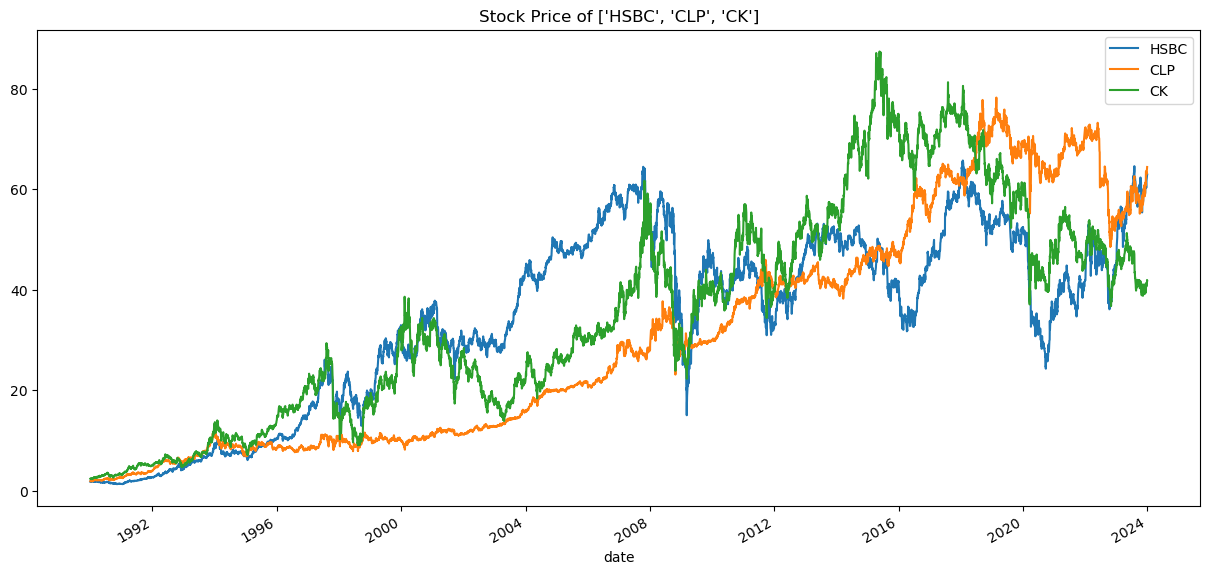

In [11]:
px = pd.read_csv('HSI_1990_2024.csv', index_col=0) # means we set column 0 as the index
px = px.rename_axis('date')
px.index = pd.to_datetime(px.index)
px.plot(figsize=(15, 7), title=f"Stock Price of {list(px.columns)}");

rets = np.log(px.ffill(limit=2)).diff()

## 1. Volatility Forecast

### 1.1 Simple Moving Standard Deviation

$L$-day moving variance of time series $X_t$ (where $L$ stands for lookback) can be defined as 

\begin{equation*}
\hat{\sigma}^2_t = \frac{1}{L - 1} \sum_{i=0}^{L-1} (X_{t-i} - \text{sma}_t) ^ 2,
\end{equation*}

We can then compute $L$-day moving standard deviation $= \sqrt{\hat{\sigma}^2_t}$

This estimate carries equal weight for these $L$ terms, even though the most recent terms should have greater impacts.

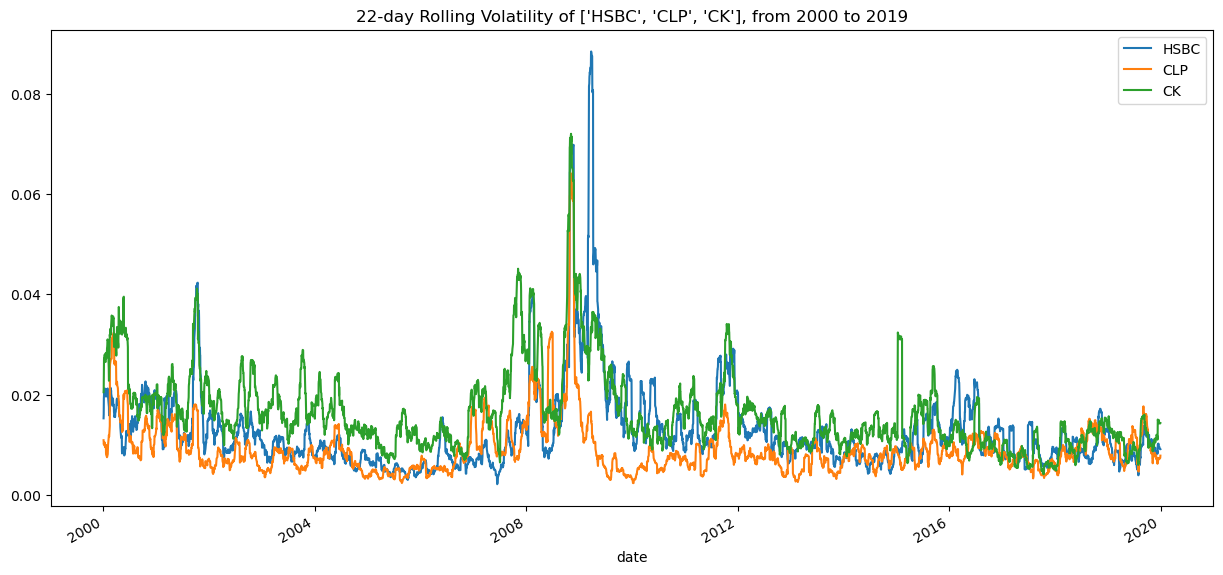

In [15]:
start, end = "2000", "2019"
lookback = 22
title=f"{lookback}-day Rolling Volatility of {list(rets.columns)}, from {start} to {end}"

vol_rolling = rets.rolling(lookback, min_periods=lookback // 3).std() 
vol_rolling.loc[start:end].plot(figsize=(15, 7), title=title);

### 1.2 Exponentially Weighted Moving Standard Deviation

To overcome the eqaul-weight problem, we introduce the Exponentially Weighted Moving Average (EWMA) model, 

which gives the highest weight to the most recent term and gradually down-weights the terms as we move back in time.

Consider time series $u_t$ with mean $0$, then its EWM variance can be **forecasted** as below: 

\begin{equation*}
\hat \sigma_t^2 =\lambda \hat \sigma_{t-1}^2+(1-\lambda )u_{t-1}^2 , \text{ where } 0 \le \lambda \le 1
\end{equation*}

If $\lambda$ is closer to 1, then the impact of $u_{t}^2$ to $\hat \sigma_t^2$ is smaller, so we call the model is smoother / slower.

#### 1.2.1 Recursive Formula

From below, we can see the "exponential" nature, in the sense that the impact of the $i^{th}$ lagged term is proportional to $\lambda^i$:

$\begin{align*}
\hat \sigma_t^2 &=\lambda \hat \sigma_{t-1}^2 + (1-\lambda) u_{t-1}^2 \\
&= \lambda [ \lambda \hat \sigma_{t-2}^2+(1-\lambda) u_{t-2}^2]+(1-\lambda ) u_{t-1}^2  \\
& = (1-\lambda ) (u_{t-1}^2 + \lambda u_{t-2}^2)+\lambda^2 \hat \sigma_{t-2}^2 \\
& \dots \\
& = (1-\lambda ) \ \sum_{i=1}^{m}\lambda^{i-1}u_{t-i}^2+\lambda^m \hat \sigma_{t-m}^2
\end{align*}$

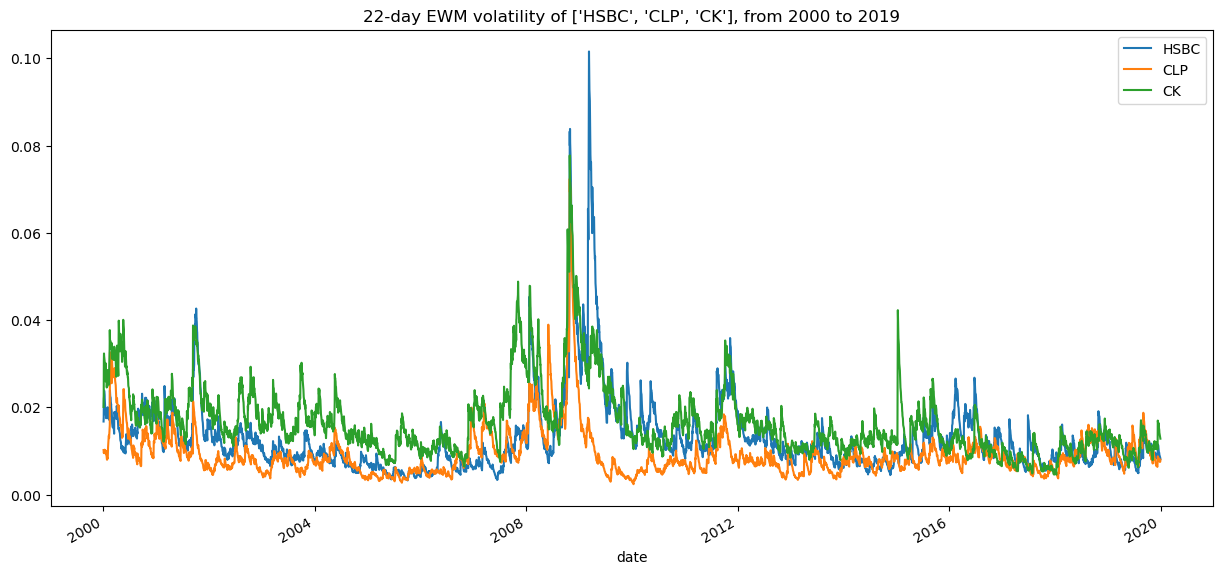

In [20]:
lookback = 22
title=f"{lookback}-day EWM volatility of {list(rets.columns)}, from {start} to {end}"

vol_ewm = rets.ewm(span=lookback, min_periods=lookback // 3).std() 
vol_ewm.loc[start:end].plot(figsize=(15, 7), title=title);

### 1.3 ARCH Model

#### 1.3.1 The Model

This model assumes that the current variance rate $\sigma_n^2$ depends on:
1. the $m$ most recent values of $u_i^2$ (autoregressive setup)
2. a long-run average variance rate $V_L$

\begin{equation*}
	\sigma_n^2=\gamma V_L+\alpha_1 u_{n-1}^2+\ldots +\alpha_m u_{n-m}^2,
\end{equation*}


where the coefficients are such that $\gamma+\alpha_1+ \ldots +\alpha_m=1$ (WHY?).

We further assume the following conditional independence of $u_i$'s:


\begin{equation*}
	\frac{u_i}{\sigma_i}\bigg| u_{i-1},u_{i-2},\dots,u_1  \overset{d}{=}  \frac{u_i}{\sigma_i} \bigg| \sigma_i \sim N(0,1).
\end{equation*}


The advantage of this model is that it introduces a **long-run variance rate**.

### 1.4 GARCH Model

#### 1.4.1 The Model

The most general GARCH model is the GARCH($p,q$) model:
\begin{equation*}
	\sigma_n^2=\gamma V_L+\alpha_1 u_{n-1}^2+\ldots + \alpha_p u_{n-p}^2+\beta_1\sigma_{n-1}^2+\ldots +\beta_q\sigma_{n-q}^2
\end{equation*}

In the EWMA model in Section 2.2, $\sigma_n^2$ is defined recursively in terms of $\sigma_{n-1}^2$ and $u_{n-1}^2$. 

In the ARCH($m$) model in Section 2.3, $\sigma_n^2$ is defined in terms of $m$ most recent values of $u_i^2$ and a long-run variance rate $V_L$. 

The GARCH model is a **hybrid** of the other two. Indeed, GARCH(1,1) model is by far the most popular one used in estimating volatility.
\begin{equation}
	\sigma_n^2=\gamma V_L+\alpha u_{n-1}^2+\beta\sigma_{n-1}^2,
\end{equation}
where $\gamma+\alpha+\beta=1$ and $V_L$ is the long-run average variance rate. Note that when $\gamma=0$, GARCH(1,1) reduces to an EWMA model. 

#### 1.4.2 Parameter Estimation

Here, we only focus on the GARCH(1,1) model. 

In general, the calibration process of the GARCH(1,1) model is by maximizing the following logarithmic likelihood function:

\begin{equation}
	l(\omega, \alpha, \beta; \mathbf u) := -\frac{1}{2} \left(N \cdot \ln (2\pi) + \sum_{n=1}^N \ln \sigma_n^2 + \sum_{n=1}^N \frac{u_n^2}{2 \sigma_n^2} \right) \
\end{equation}

In practice, we can initialize $\sigma_0^2$ with
1. the long run variance: $\sigma_0^2 := \omega / (1 - \alpha - \beta)$;
2. mean of $u^2$: $\sigma_0^2 := \omega + \alpha \cdot \overline{u^2} + \beta \cdot \overline{u^2}$;
3. the variance of $u$: $\sigma_0^2 := {\rm Var}(u)$,

where
\begin{equation*}
	\overline{u^2} := \frac{1}{N} \sum_{n=1}^N u_n^2 \, , \qquad {\rm Var}(u) := \frac{1}{N-1} \sum_{n=1}^N (u_n - \overline{u})^2 \, , \qquad \text{and} \qquad \overline{u} := \frac{1}{N} \sum_{n=1}^N u_n \, .
\end{equation*}

With different initialization of $\sigma_0^2$ and the parameters $\mathbf \theta = (\omega, \alpha, \beta)^\top$, we arrive at different MLEs. 

#### 1.4.3 Demo -- arch package

In [31]:
u = rets.HSBC.loc['2010':'2019'].fillna(0)
res_HSBC = arch.arch_model(u, mean='Zero', vol='GARCH', 
                      p=1, q=1, power=2.0, dist='normal',
                      hold_back=0, rescale=False).fit(disp='off') 

res_HSBC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   HSBC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7478.19
Distribution:                  Normal   AIC:                          -14950.4
Method:            Maximum Likelihood   BIC:                          -14933.0
                                        No. Observations:                 2463
Date:                Thu, Nov 13 2025   Df Residuals:                     2463
Time:                        01:14:15   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.0913e-06  3.773e-13  8.192e+06      0.000 [3.091e-06,3.091e-06]
alpha[1]       0.0500  7.800e-07  6.410e+04      0.000 [5.000e-02,5.000e-02]
beta[1]        0.9300  3.165e-03    293.867      0.000     [  0.924,  0.936]
============================================================================

Covariance estimator: robust
"""

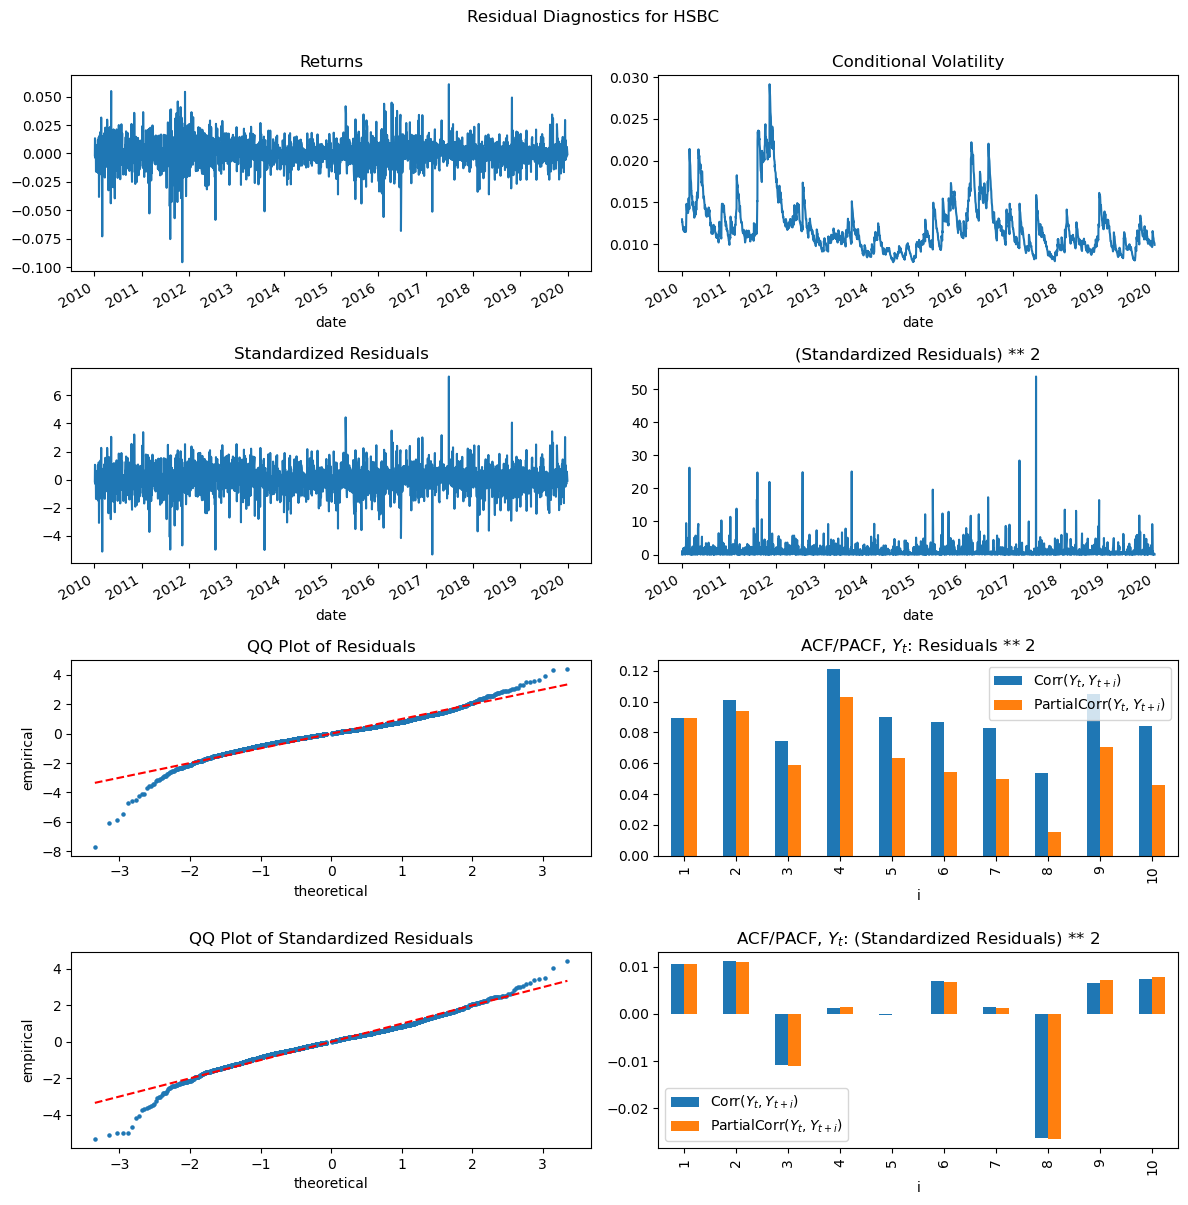

In [32]:
resid_plot(res_HSBC)

We can see that after fitting GARCH model:

1. Our normalized residuals are less fat-tailed. 
2. Autocorrelation in shock magnitude is also removed.

#### 1.4.3 Forecasting Future Volatilities

Once the MLEs of $\omega$, $\alpha$, $\beta$ are obtained, we can forecast the future volatilities by using this GARCH(1,1) model. Since
\begin{align*}
	\hspace{2cm}
	\sigma_n^2 &= \omega + \alpha u_{n-1}^2 + \beta \sigma_{n-1}^2\\
	&= (1-\alpha-\beta)V_L+\alpha u_{n-1}^2 + \beta \sigma_{n-1}^2,
\end{align*}
therefore, $\sigma_n^2 - V_L = \alpha (u_{n-1}^2-V_L)+\beta(\sigma_{n-1}^2-V_L)$.

On the day $n+k$ in the future,
\begin{flalign*}
	\hspace{2cm}
	\sigma_{n+k}^2-V_L=\alpha (u_{n+k-1}^2-V_L)+\beta (\sigma_{n+k-1}^2-V_L). &&
\end{flalign*}
For GARCH(1,1) model, we can also estimate the covariances of two assets as
\begin{equation}
	\text{cov}_{n+t}=\omega+\alpha x_{n+t-1} y_{n+t-1} + \beta \text{cov}_{n+t-1} \text{ and } \rho_{n+t}=\frac{\text{cov}_{n+t}}{\sigma_{x, n+t}\sigma_{y, n+t}}
\end{equation}	

## 2. Kelly's Formula

### 2.1 Motivation

Suppose that a profit-maximizing investor is deciding when to sell a stock over a fixed time period.

A reasonable refomulation is: When should he sell the stock in order to minimize the expected relative error between the selling price and the “true” maximum price?

### 2.2 Goodness Index $\alpha$

Shiryaev showed that under a Black-Scholes market, 

Define the goodness index $\alpha := \mu/\sigma^2$, where $\mu$ and $\sigma$ are respectively the expected rate of the return and the volatility

One should buy a stock and hold it until the end of the investment period $T$ when $\alpha \geq 1/2$; otherwise, one should sell it at once when $\alpha < 1/2$.

\begin{align*}
dS_t &= \mu S_t dt + \sigma S_t dW_t \\
\implies \mathbb{E}[\ln{\frac{S_t}{S_0}}] &= (\mu - \frac{\sigma^2}{2}) t 
\end{align*}

Clearly, $\alpha > \frac{1}{2}$ is equivalent to a positive expected log returns of $S_t$

### 2.3 Long-term Wealth Maximization

Next, consider a portfolio:
\begin{equation*}
\Pi_t = w_t S_t + (1-w_t) B_t, \text{ where } S_0 = B_0 = 1,
\end{equation*}

$w_t \in [0,1]$ is the weight on one risky asset $S_t$,

and $B_t$ is a risk-free asset such that $dB_t = rB_tdt$:

\
One can similarly show:

\begin{align*}
\text{Define } f_t &:= \frac{w_t S_t}{\Pi_t} \\
\mathbb{E}[ d \ln (\Pi_t) ] &= (r + (\mu - r)f_t - \frac{\sigma^2}{2} f_t^2) dt \\
\implies f_t^* &= \frac{\mu - r}{\sigma^2}
\end{align*}

$f_t^*$ is known as the Kelly's fraction, which is the % of dollar allocated in $S_t$.

There are many other methods to compute an 'optimal' portfolio weight, e.g. Mean-Variance Optimization. 

It depends on how you define your objective functions and constraints.

### 2.4 Discrete Time, Binary Outcomes

Usually, when people talk about Kelly fraction $f^*$, they refer to a casino like setting, 

where you play the same game a number of times, and the outcome is either winning or losing a certain amount of money.

Then, let $p$ be the winning probability, $n$ the the number of games played, so $X \sim Bin(n, p)$

Also, let $a, b$ be the $\%$ win/lose, and $f$ be your bet size.

Then: 
\begin{align*}
\mathbb{E} [\ln(W_n / W_0)] &= np \ln (1 + fa) + n(1 - p) \ln(1 - fb) \\
\implies \frac{pa}{1 + f^*a} &= \frac{(1-p)b}{1-f^*b} \\
\implies f^* &= \frac{p}{b} - \frac{1-p}{a}
\end{align*}

(In the casion setting, you lose all your bet if the outcome is against you, so $b$ is simply $100\%$.)

In [45]:
p = np.linspace(0.01, 1, 101)
a = np.linspace(0.001, 2, 2001)

kelly_fraction = p[:, None] - (1-p)[:, None] / a[None, :]
kelly_fraction = pd.DataFrame(kelly_fraction, index=p, columns=a)
kelly_fraction = kelly_fraction.clip(lower=0)
kelly_fraction = kelly_fraction.rename_axis(index='win_prob (p)').rename_axis(columns='odds (a)')

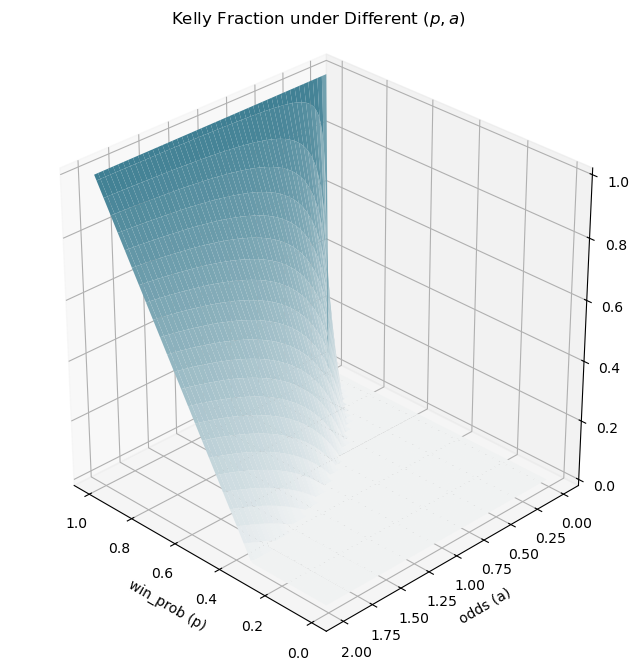

In [46]:
plot_surface(kelly_fraction, title=f'Kelly Fraction under Different $(p, a)$',
             azim=135, elev=30, contour=False, figsize=(8, 8), center=0);